In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
#Random forest
from sklearn.ensemble import RandomForestRegressor
#biblioteque pour  comparer
from sklearn.metrics import r2_score
#Randomized search
from sklearn.model_selection import RandomizedSearchCV
#Gridsearch
from sklearn.model_selection import GridSearchCV
#Kfold
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble

In [36]:
train_data = pd.read_csv('cars_data.csv')
train_data = train_data.drop(['Unnamed: 0'], axis=1)
train_data['model'] = train_data['model'].astype('category').cat.codes
train_data.dropna(axis=0, inplace=True)
#toujours reset index apres dropna
train_data=train_data.reset_index()

# Faire test sans 'model'
# train_data=train_data.drop('model', axis=1)

#drop l'index generé par reset_index 
train_data=train_data.drop('index', axis=1)

In [37]:
#Cree une copie pour travailler dans le ML (deep=True) bien garde
X = train_data.copy(deep=True)
#drop the Price
X=X.drop('Price', axis=1)
#asigne the y to price
y = train_data.Price

In [38]:
#on tranform y en array pour travailler avec le modele de ML
y=pd.DataFrame(y)

In [39]:
print("Shape of input data: {} and shape of target variable: {}".format(X.shape, y.shape))

X.head() # Show first 5 training examples
X.info()

Shape of input data: (24398, 9) and shape of target variable: (24398, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24398 entries, 0 to 24397
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   model               24398 non-null  int8   
 1   year                24398 non-null  int64  
 2   Gas Mileage         24398 non-null  float64
 3   Engine              24398 non-null  float64
 4   Drivetrain          24398 non-null  float64
 5   Passenger Capacity  24398 non-null  int64  
 6   Passenger Doors     24398 non-null  int64  
 7   Body Style          24398 non-null  float64
 8   Transmission        24398 non-null  float64
dtypes: float64(5), int64(3), int8(1)
memory usage: 1.5 MB


In [40]:
#Train split test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [41]:
# random forest avant randomized search avec des parametres a la main
rf = RandomForestRegressor(n_estimators=1000, max_depth=10)

In [42]:
rf.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_depth=10, n_estimators=1000)

In [43]:
predict_price_test=rf.predict(X_test)
predict_price_train=rf.predict(X_train)

In [44]:
print(predict_price_test)
print(predict_price_train)

[ 26902.3242317   37899.95141939  30484.43358015 ...  28344.44463268
 100171.80770058  24684.82023079]
[29998.93287324 32982.29527424 19262.19385645 ... 32959.25156724
 21624.15126999 36307.52447692]


In [45]:
#Compare y_test(valeur reels) contre valeurs de prix predictes sur X_test
print("R2 test :", r2_score(y_test, predict_price_test))
#la grosse entre les R2 test et train, ça veut dire on a overfitte le modele
print("R2 train :", r2_score(y_train, predict_price_train))

R2 test : 0.9247789737770158
R2 train : 0.9420741891519756


In [46]:
rf = RandomForestRegressor()

#parametres pour randomizedsearch et gridsearch
n_estimators = [int(x) for x in np.linspace(start=100, stop=200, num=10)]
print("n_estimators :", n_estimators)
max_features = [None, 'auto', 'sqrt']
max_depth = [10, 14, 18]
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}
#Appel a rds (enlever les commentaires pour lancer le randomizedsearch)
clf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, verbose=3,
n_jobs=2, return_train_score=True, scoring="r2")

#Gridsearch, faut utiliser le randomized plutot
# clf = GridSearchCV(estimator=rf, param_grid=param_grid, verbose=3,
# n_jobs=2, return_train_score=True, scoring="r2")

#values.ravel c'est utilise pour arranger l'array 
#clf va substituer le rf dans le fit
clf.fit(X_train, y_train.values.ravel())

#Meilleures parametres/config
print("Best params :", clf.best_params_)

#C'est recuperer le meilleur algorithme trouve par randomized search
model = clf.best_estimator_

model.fit(X_train, y_train.values.ravel())


predict_price_test=clf.predict(X_test)
predict_price_train=clf.predict(X_train)

#Compare y_test(valeur reels) contre valeurs de prix predictes sur X_test
print("R2 test :", r2_score(y_test, predict_price_test))
#la grosse entre les R2 test et train, ça veut dire on a overfitte le modele
print("R2 train :", r2_score(y_train, predict_price_train))

n_estimators : [100, 111, 122, 133, 144, 155, 166, 177, 188, 200]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params : {'n_estimators': 166, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 18, 'bootstrap': True}
R2 test : 0.9369812871270111
R2 train : 0.9809487929004702


In [47]:
# Lets split the data into 5 folds.  
# We will use this 'kf'(KFold splitting stratergy) object as input to cross_val_score() method
kf =KFold(n_splits=5, shuffle=True, random_state=42)

#rf = RandomForestRegressor(n_estimators=1000, max_depth=10) avant randomized search
#avec des paramtres a la main

rf = RandomForestRegressor()

n_estimators = [int(x) for x in np.linspace(start=100, stop=200, num=10)]
print("n_estimators :", n_estimators)
max_features = [None, 'auto', 'sqrt']
max_depth = [10, 14, 18]
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}
#Appel a rds (enlever les commentaires pour lancer le randomizedsearch)
clf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, verbose=3,
n_jobs=2, return_train_score=True, scoring="r2", cv=kf)

# #Gridsearch, faut utiliser le randomized plutot
# clf = GridSearchCV(estimator=rf, param_grid=param_grid, verbose=3,
# n_jobs=2, return_train_score=True, scoring="r2")

#values.ravel c'est utilise pour arranger l'array 
#clf va substituer le rf dans le fit
clf.fit(X_train, y_train.values.ravel())

#Meilleures parametres/config
print("Best params :", clf.best_params_)

#C'est recuperer le meilleur algorithme trouve par randomized search
model = clf.best_estimator_

model.fit(X_train, y_train.values.ravel())


predict_price_test=clf.predict(X_test)
predict_price_train=clf.predict(X_train)

#Compare y_test(valeur reels) contre valeurs de prix predictes sur X_test
print("R2 test :", r2_score(y_test, predict_price_test))
#la grosse entre les R2 test et train, ça veut dire on a overfitte le modele
print("R2 train :", r2_score(y_train, predict_price_train))

n_estimators : [100, 111, 122, 133, 144, 155, 166, 177, 188, 200]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params : {'n_estimators': 166, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 18, 'bootstrap': False}
R2 test : 0.944893264109106
R2 train : 0.983807777866807


In [48]:
#liée au kfold
score = cross_val_score(model, X_train, y_train.values.ravel(), cv=kf, scoring="r2")
print("\nKfold score mean :", score.mean() * 100.0)
print("Kfold std deviation :", score.std() * 100.0)
print("Kfold accuracy for each kfold :", score)
print("Kfold variance :", score.var())


Kfold score mean : 93.5403461758686
Kfold std deviation : 0.6601175293978018
Kfold accuracy for each kfold : [0.94326836 0.92541105 0.93025703 0.94031162 0.93776924]
Kfold variance : 4.357551526182577e-05


Text(0.5, 0, 'Relative Importance')

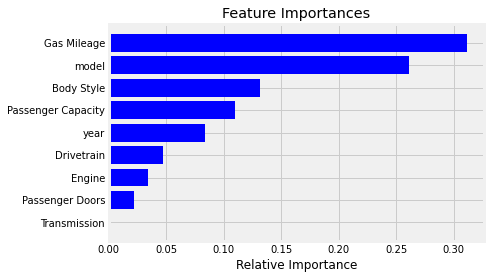

In [49]:
liste_variables=list(X.columns)
importances = model.feature_importances_ #infos donnes par randomforest
indices = np.argsort(importances)
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance')